# Example measurement system's flow v 2.0

In this workbook, we demonstrate another type of information quality check -- when the information that is recorded contains less information than the information downloaded from the database. 

This demonstrates the check when our measured entity's attributes are out of bound for some reason. 

## Part 1: configuration

In [1]:
# now we add the logging to note whether something has actually gone wrong
import logging
logging.basicConfig(filename='./information_quality_v2.log', 
                    filemode='w',
                    format='%(asctime)s;%(name)s;%(levelname)s;%(message)s',
                    level=logging.DEBUG)

logger = logging.getLogger('MI_defects_v2')

logger.info('Configuration started')

In [2]:
try:
    import requests
    import os.path
    import math
    import time
    import datetime
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
except Exception as e:
    logger.error(f'Exception caught when importing libraries: {e.msg}')

In [3]:
HISTORY_DAYS = 21                # Days of data to download
PREDICT_DAYS = 21                # days to predict

# Data sources
# This should work for any Bugzilla server, just change the URL and pick a (case-sensitive) "product" from their data.
# Have a look here for more ideas: https://www.bugzilla.org/installation-list/
BUGZILLA={"url": "https://bugs.webkit.org", "product": "WebKit"}
#BUGZILLA={"url": "https://gcc.gnu.org/bugzilla", "product": "gcc"}
#BUGZILLA={"url": "https://bugzilla.mozilla.org", "product": "Firefox"}

In [4]:
logger.info('Configuration ended')

Not much can go wrong in the above code, but:
* _missing libraries_
* _warning suppression_

We can catch the warnings, the missing libraries and errors here. We do not do much with these exceptions, but we log them. 

We could chose another way - just log everything and do not handle exceptions manually. However, this way of handling exceptions gives us the control of what we write in the log file. This control is important later when we develop the information quality system based on the information from the log file. 

In that information quality system we can then look for specific events rather than parse what each event could result in. 

## Part 2: export from the database

This is the interesting part. In this version of the measurement system, we store the old version of the export, export the new one and make a basic information quality check -- that the information is more fresh than the information downloaded from the database. 

IMPORTANT! Since I cannot control when this error actually happens, I simulate it here. I've prepared the current data file so that it contains one defect reported in the future. 

In [42]:
#####################################
# Data Extraction, Storage and Access
#####################################
# RAW_DATA is a pandas dataframe representing a complete table of the data, one row per reported defect.

# Download up-to-date data to local filesystem
def download_csv(filename, bugzilla_url, product, days):
    data_url=bugzilla_url + "/buglist.cgi"
    data_params = {
        #"product": "WebKit",
        "product": product,
        "query_format": "advanced",
        "bug_status": [ "NEW", "ASSIGNED", "REOPENED", "RESOLVED", "CLOSED" ],
        "x_axis_field": "resolution",
        "y_axis_field": "assigned_to",
        "ctype": "csv",
        "columnlist": "bug_id,product,component,assigned_to,bug_status,resolution,opendate,changeddate",
        "chfieldto": "Now",
        "chfieldfrom": "-{}d".format(days)
    }
    
    logger.info("Downloading fresh data to {}".format(filename))
    r = requests.get(data_url, params=data_params)
    with open(filename, "w") as f:
        f.write(r.text)

# Returns a pandas dataframe of the raw source data
# please note the extended checking for file existence
def get_data(bugzilla_url, product, days):
    filename = "data_{}_{}.csv".format(product,days)
    filename_previous = "data_{}_{}_previous.csv".format(product,days)
    
    # here we check that the file exists, 
    # and if it does, then we copy it under 
    # a new name
    if not os.path.exists(filename):
        download_csv(filename, bugzilla_url, product, days)
    else: 
        logger.info(f'File exists, saving the existing into {filename_previous}')
        #os.rename(filename,filename_previous)                                      # this line is commented as I already injected the fault
        logger.info('Downloading the new file. ')
        download_csv(filename, bugzilla_url, product, days)
    
    logger.info('Data download complete')
    logger.info('Start checking timeliness')

    # checking that the last reported defect
    # in the new database is not before the last
    # reported defect from the newly downloaded data
    df = pd.read_csv(filename, header=0, parse_dates=["opendate", "changeddate"])
    df_previous = pd.read_csv(filename_previous, header=0, parse_dates=["opendate", "changeddate"])
    
    # find the latest defects in both files
    df.sort_values(by='opendate', inplace=True,)
    df_previous.sort_values(by='opendate', inplace=True,)

    # extract the timestamp of these two latest defects
    last_defect_current_date = df.tail(1)['opendate'].values[0]
    last_defect_previous_date = df_previous.tail(1)['opendate'].values[0]

    # here we check that the dates of the old defects are not later
    # than the dates of the new defects
    # if this is the case, then we log this as an error 
    # in the information quality log
    if (last_defect_previous_date >= last_defect_current_date):
        logger.error('TIMELINESS')

    logger.info('Done checking timeliness')

    return df

RAW_DATA = get_data(BUGZILLA["url"], BUGZILLA["product"], HISTORY_DAYS)

Now, we did catch the error, but we still have the data, so the calculations can continue. We can, however, notify the stakeholder about the information quality problems. He/she will get the value of th indicator, but also will know that it is a wrong value as there is a problem with the information quality. 

## Part 3: base measures


In [3]:
#################################################
# Measurement Methods (generating base measures)
#################################################

# Returns a dataframe. The actual measure is the number of data elements in the dataframe.
base_new      = lambda df,ldate,udate: df[  (df["opendate"] >= ldate)
                                        &   (df["opendate"] < udate)
                                         ]

base_resolved = lambda df,ldate,udate: df[  (df["changeddate"] >= ldate)
                                        &   (df["changeddate"] < udate)
                                        #&   (df["assigned_to"] != 'webkit-unassigned')
                                        #&   (df["assigned_to"] != "commit-queue")
                                        &   (df["bug_status"] == 'RESOLVED')
                                         ]
                                         
def count(df):
    return len(df.index)

def daily_series(df, method):
    global HISTORY_DAYS
    y = []
    x = []
    for day in range(HISTORY_DAYS):
        startdate = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=(day+1)))
        enddate = pd.Timestamp(datetime.date.today() - datetime.timedelta(days=day))
        y = [ count(method(df,startdate, enddate)) ] + y
        x = [ -day ] + x
    return x,y

In [6]:
###################################
# Base Measures (as daily series)
###################################

dnx, daily_new = daily_series(RAW_DATA, base_new)

drx, daily_resolved = daily_series(RAW_DATA, base_resolved)

In the above code, we can mostly get problems with:
* _calculations_
* _missing values_
* _missing data_

Visualization of the base measure trend


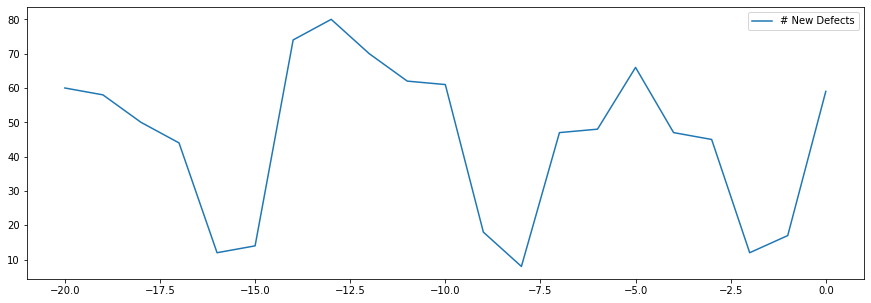

In [7]:
print("Visualization of the base measure trend")
plt.plot(dnx, daily_new, label="# New Defects")
plt.gcf().set_size_inches(15,5)
_=plt.legend()

Since we are using libraries, we probably do not get into any trouble in our code, but:
* _libraries can generate some warnings or errors_
* _the diagram can be plotted outside of the area_

## Part 4: Derived measures

In [5]:
#########################################
# Measurement Functions (generating derived measures from base measures)
#########################################

der_assigned_developers = lambda daily_developers: int(np.sum(daily_developers[-1:-8:-1]) / 7)

der_resolved_per_devday = lambda daily_resolved: np.sum(daily_resolved) / np.average(daily_resolved)

def der_predicted_defects(daily_new, predict_days, show=False):
    # 0 is first day after history, 6 is last day of history, etc.
    idx_by_weekday = [None]*7
    hist_by_weekday = [None]*7
    function_by_weekday = [None]*7
    pred_by_weekday = [None]*7
    n_predictions_per_weekday = int(math.ceil(predict_days / 7))
    for wd in range(7):
        start_sample = len(daily_new) - (7 - wd)
        # All the mondays, from oldest to newest
        hist_by_weekday[wd] = list(reversed(daily_new[start_sample:0:-7]))
        idx_by_weekday[wd] = range(-len(hist_by_weekday[wd]),0)
        
        # Find a 3rd degree polynomial that fits this progression
        function_by_weekday[wd] = np.polyfit(idx_by_weekday[wd], hist_by_weekday[wd], deg=3)
        
        # Predict the number of new defects for future mondays
        idx_pred = list(range(0, n_predictions_per_weekday))
        pred_by_weekday[wd] = np.polyval(function_by_weekday[wd], idx_pred)        

    # Interlace the weekday predictions into a sequence of days
    pred_x = list(range(predict_days))
    pred_y = [0] * predict_days
    for i in range(predict_days):
        wd = i % 7
        wdi = int(i / 7)
        pred_y[i] = max(pred_by_weekday[wd][wdi], 0)
    
    # Show the curve-fitting and prediction for one of the weekdays
    if show:
        wd=4
        idx_hist = idx_by_weekday[wd]
        idx_pred = range(-len(hist_by_weekday[wd]),0 + int(predict_days / 7))
        poly = np.polyval(function_by_weekday[wd], idx_pred)
        plt.plot(idx_hist, hist_by_weekday[wd], label="Historic data")
        plt.plot(idx_pred, poly, label="Polynomial prediction")
        plt.legend()
        
    return pred_x,pred_y
    

Here, the problems are similar to the problems with the base measures, plus:
* _mathematical calculations can result in division by 0_
* _values can be completely out of bounds, e.g. number of defects < 0_


Predicted new defects for one weekday:


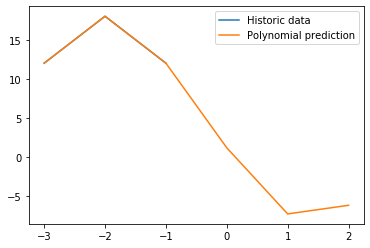

In [8]:
print("Predicted new defects for one weekday:")
_=der_predicted_defects(daily_new, PREDICT_DAYS, show=True)

Same as for the base measures: _libraries can generate warnings or errors_

In [9]:
###################################
# Derived Measures
###################################
pnew_x,pnew_y = der_predicted_defects(daily_new, PREDICT_DAYS, show=False)

defs_per_devday = der_resolved_per_devday(daily_resolved)

Predicted new defects for 21 days into the future: 626


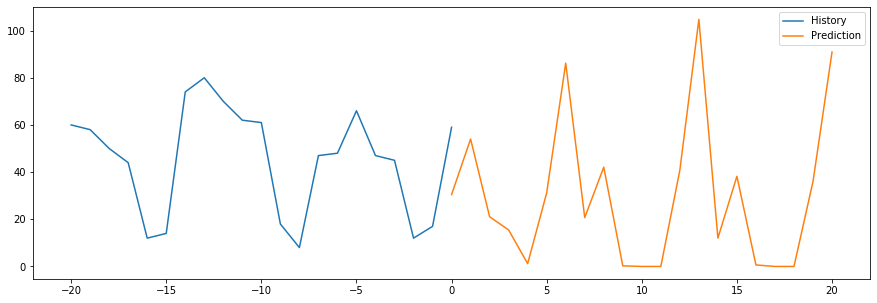

In [10]:
print(f'Predicted new defects for {PREDICT_DAYS} days into the future: {np.sum(pnew_y):.0f}')
plt.plot(dnx, daily_new, label="History")
plt.plot(pnew_x, pnew_y, label="Prediction")
plt.gcf().set_size_inches(15,5)
_=plt.legend()

Same as previously - _libraries can generate warnings or errors_

## Part 5: Indicators

In [11]:
###################################
# Analysis Models (indicators from derived measures)
###################################

# Returns (devs_needed,indicator)
# indictator is 'green', 'yellow' or 'red'
def ind_inflow_ok(expected_defects, defs_per_devday):
    average_inflow = np.sum(expected_defects) / PREDICT_DAYS
    indicator = 0
    if ( average_inflow > 40):
        indicator = 'red'
    elif ( average_inflow < 5):
        indicator = 'green'
    else:
        indicator = 'yellow'
    return (average_inflow,indicator)

The code above is robust, but in general, this is what can go wrong here:
* _the analysis model does not cover all the spectrum, boundary conditions missing_
* _the analysis model is not well-defined and more than 3 steps are needed_
* _what happens if the value of the average inflow is error_

In [ ]:
###################################
# Indicators
################################### 

expected_need,indicator_color = ind_inflow_ok(pnew_y, defs_per_devday)

In [12]:
print(f'Expected average of {expected_need:.0f} defects per day in the next {PREDICT_DAYS} days.')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_facecolor(indicator_color)


NameError: name 'expected_need' is not defined

Same as in the previous examples - _libraries can generate warnings or errors_